In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import pandas as pd
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import os
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from torch.nn import functional as F
import torchvision

In [2]:
def pre_datadealer(annotations_file):
    df = pd.read_csv(annotations_file)
    label_list=df['label'].tolist()
    labels = set(label_list)
    label2num = {}
    num2label = {}
    i = 0
    for x in labels:
        label2num[x] = i
        num2label[i] = x
        i+=1
    return label2num,num2label
    
#Adjust according to your data location
label2num,num2label=pre_datadealer("H:/classify-leaves/classify-leaves/train.csv")

In [3]:
class leave_data(Dataset):
    def __init__(self,annotations_file,img_dir,train = False):
        super().__init__()
        self.train=train
        if self.train:
            self.img_labels = pd.read_csv(annotations_file)[0:14001]
        else:
            self.img_labels = pd.read_csv(annotations_file)[14001:-1]
        self.img_dir = img_dir
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self,idx):
        
        label = label2num[self.img_labels.iloc[idx, 1]]
        rela_img_path = self.img_labels.iloc[idx,0]
        img_path = os.path.join(self.img_dir,rela_img_path).replace('\\','/')
        img = transforms.ToTensor()(Image.open(img_path))
        return img,label

In [4]:
#Adjust according to your data location
img_dir = "H:/classify-leaves/classify-leaves/"
train_csv = "H:/classify-leaves/classify-leaves/train.csv"

train_dataset = leave_data(train_csv,img_dir,train=True)
test_dataset = leave_data(train_csv,img_dir,train=False)
train_iter = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_iter = DataLoader(test_dataset,batch_size=64,shuffle=True)

In [5]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_normal_(m.weight)

In [6]:
net = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)
net.fc = nn.Linear(in_features=512, out_features=176, bias=True)
net.fc.apply(init_weights)

Linear(in_features=512, out_features=176, bias=True)

In [7]:
def evaluate(net,data_iter,device=None):
    #use GPU to calculate
    if isinstance(net, nn.Module):
        net.eval() 
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [8]:
def save_model(net):
    model_path = 'train_model.pt' 
    torch.save(net.state_dict(),model_path)

In [9]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    print('training on', device)
    best_acc = 0
    net.to(device)
    parames = [parame for name,parame in net.named_parameters() if name not in ["fc.weight","fc.bias"]]
    #Adjust if needed
    optimizer = torch.optim.Adam([{"params":parames},
                            {"params":net.fc.parameters(),"lr":lr*8}],lr=lr)
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate(net, test_iter)
        if test_acc > best_acc:
            save_model(net)
            best_acc = test_acc
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.062, train acc 0.981, test acc 0.917
31.8 examples/sec on cuda:0


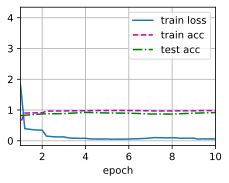

In [10]:
lr, num_epochs, batch_size = 1e-4, 10, 32
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())